# **Installation and import important libraries**

In [1]:
!pip install tensorflow_addons
!pip install tensorflow==2.12.0
!pip install tensorflow-addons==0.19.0

  Using cached tensorflow_addons-0.19.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.19.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0


### **Connect with kaggle**

In [2]:
#connect with kaggle API with a token uploaded as "kaggle.json" file
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
import keras
from keras.applications.vgg16 import VGG16 , preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential ,Model
from keras.layers import Dense, Dropout, Activation ,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam,Adamax
from tensorflow import keras;
from keras import layers;
from keras import metrics
import tensorflow as tf
import tensorflow_addons as tfa
from keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras import callbacks
from keras import regularizers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


### **Load Dataset**

In [4]:
! kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 98% 59.0M/60.3M [00:03<00:00, 28.4MB/s]
100% 60.3M/60.3M [00:03<00:00, 20.2MB/s]


In [5]:
! unzip "/content/fer2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [6]:
num_of_classes = 7
train_path = "/content/train"
test_path = "/content/test"
image_size = [48,48]
batch_size = 64

# **Data Visualization**

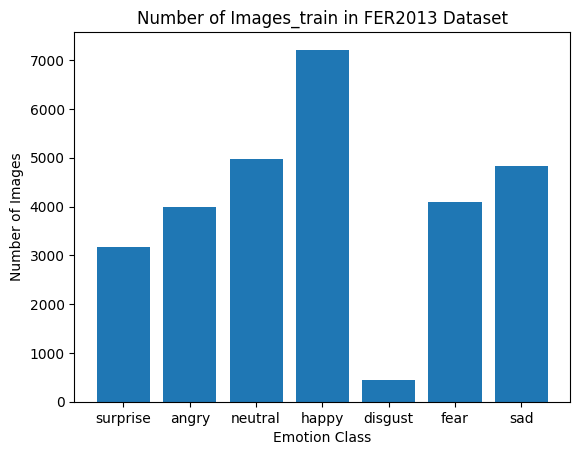

In [7]:
# Create a dictionary to store the number of images in each class
counts = {}

# Loop over the subdirectories and count the number of images in each class
for subdir in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, subdir)):
        counts[subdir] = len(os.listdir(os.path.join(train_path, subdir)))

# Plot the bar chart
plt.bar(range(len(counts)), list(counts.values()))
plt.title('Number of Images_train in FER2013 Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(counts)), list(counts.keys()))
plt.show()

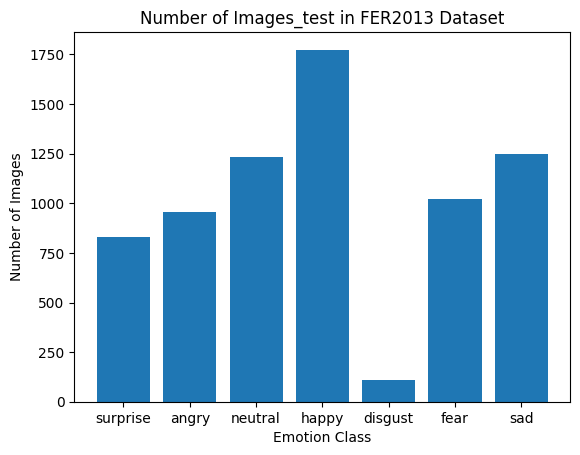

In [8]:
# Create a dictionary to store the number of images in each class
counts = {}

# Loop over the subdirectories and count the number of images in each class
for subdir in os.listdir(test_path):
    if os.path.isdir(os.path.join(test_path, subdir)):
        counts[subdir] = len(os.listdir(os.path.join(test_path, subdir)))

# Plot the bar chart
plt.bar(range(len(counts)), list(counts.values()))
plt.title('Number of Images_test in FER2013 Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(counts)), list(counts.keys()))
plt.show()

## Load data and make augmentation

In [9]:
train_data_gen = ImageDataGenerator(
					rotation_range=10,
					shear_range=0.2,
					horizontal_flip=True,
					rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [10]:
# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        train_path,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        test_path,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **DL Model Architecture**

In [11]:
model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256,kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(num_of_classes, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 activation_1 (Activation)   (None, 24, 24, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                    

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, decay=1e-6),
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=7,average='macro' )])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
early_stop = callbacks.EarlyStopping(patience = 20 , monitor = 'val_loss')

In [15]:
# Train the neural network/model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=7178 // 64,
        callbacks = [early_stop])

<ipython-input-15-1cb05e0f31b8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
448/448 [==============================] - 1403s 3s/step - loss: 3.9190 - accuracy: 0.3172 - f1_score: 0.2307 - val_loss: 2.7240 - val_accuracy: 0.4000 - val_f1_score: 0.2913
Epoch 2/5
448/448 [==============================] - 1368s 3s/step - loss: 2.0654 - accuracy: 0.4439 - f1_score: 0.3501 - val_loss: 1.8494 - val_accuracy: 0.4369 - val_f1_score: 0.2828
Epoch 3/5
448/448 [==============================] - 1352s 3s/step - loss: 1.6165 - accuracy: 0.4973 - f1_score: 0.4013 - val_loss: 1.5716 - val_accuracy: 0.4872 - val_f1_score: 0.3641
Epoch 4/5
448/448 [==============================] - 1344s 3s/step - loss: 1.4180 - accuracy: 0.5315 - f1_score: 0.4339 - val_loss: 1.3863 - val_accuracy: 0.5379 - val_f1_score: 0.4409
Epoch 5/5
448/448 [==============================] - 1357s 3s/step - loss: 1.3102 - accuracy: 0.5506 - f1_score: 0.4523 - val_loss: 1.3280 - val_accuracy: 0.5416 - val_f1_score: 0.4458


In [ ]:
# save model
model.save('model.h5')

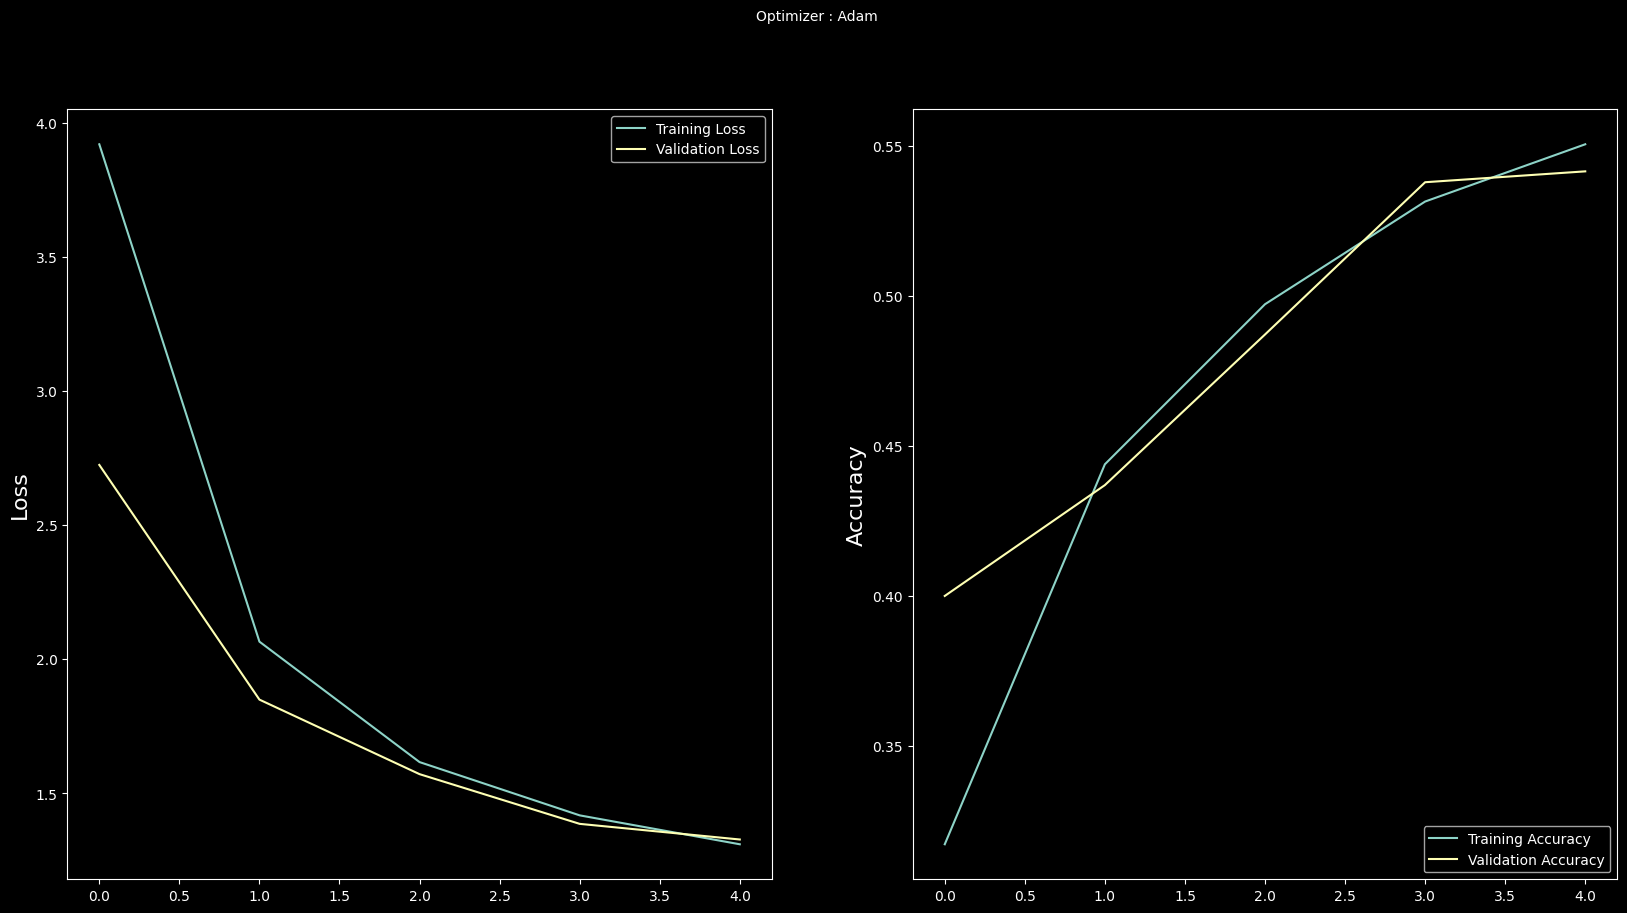

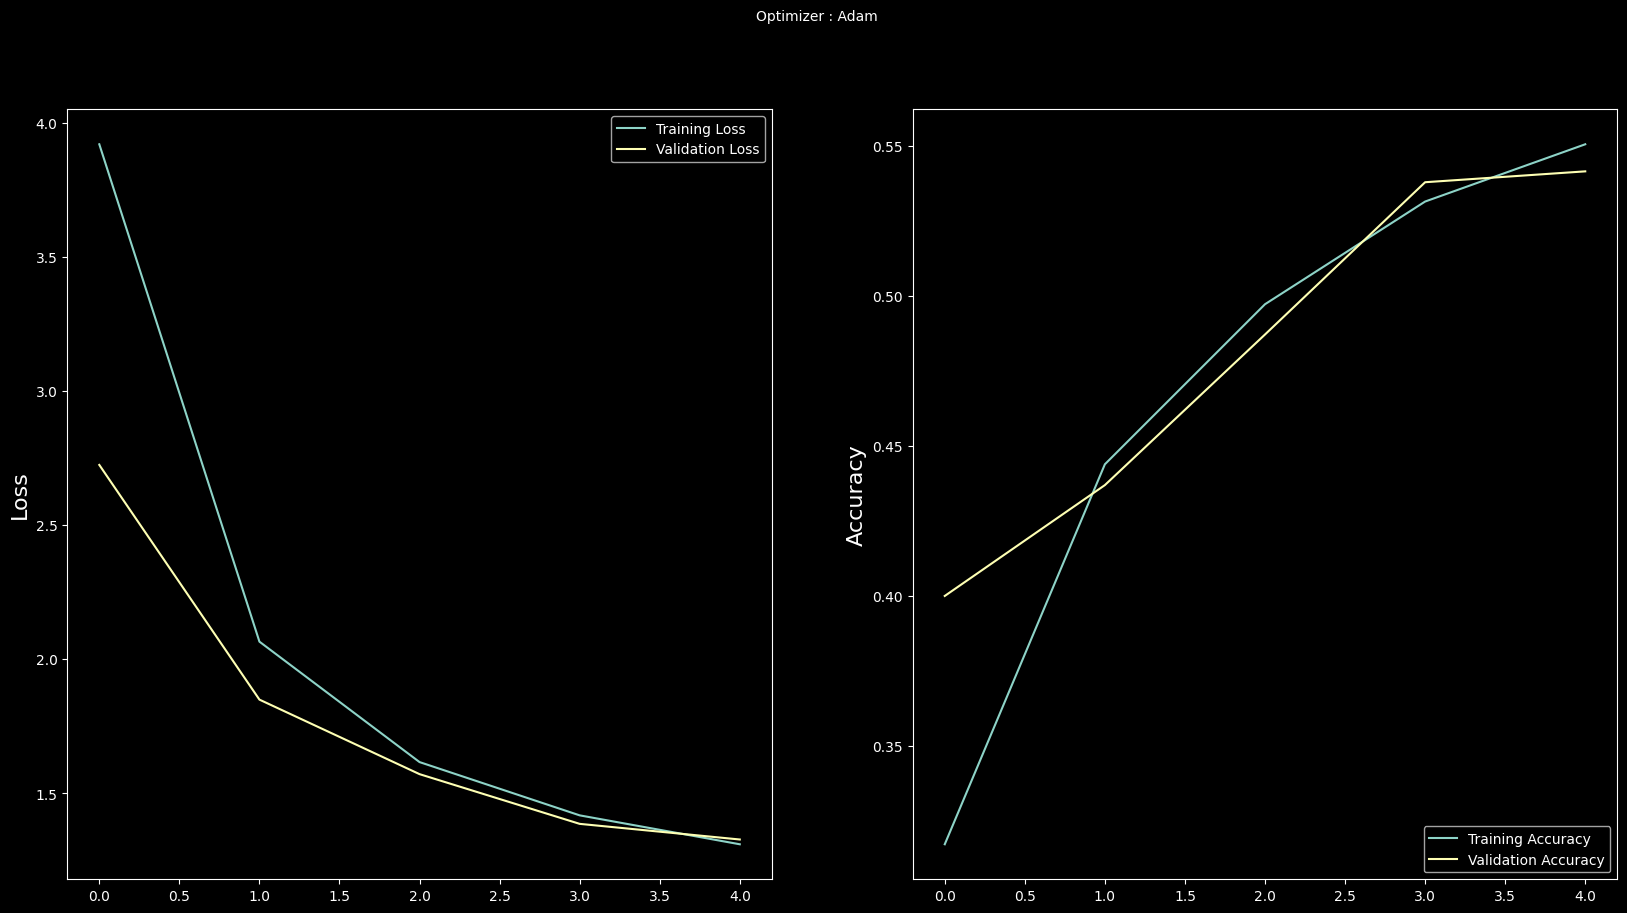

In [17]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

#**Testing the model**

1/1 [==============================] - 0s 119ms/step
[[0.21328299 0.03099513 0.10720693 0.2772762  0.14188969 0.18490657
  0.0444425 ]]
3
The predicted emotion in the image is: happy


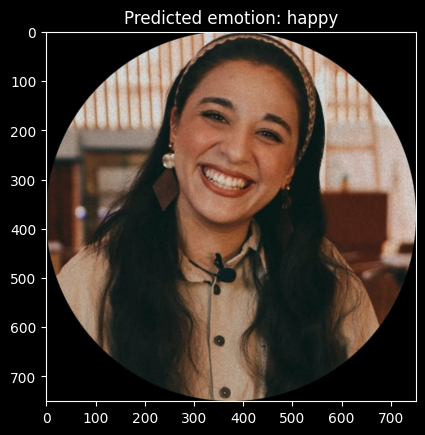

In [22]:
# Preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (48, 48))
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    return image
model = tf.keras.models.load_model('/content/model.h5')
# Define a function to predict the emotion in the image
def predict_emotion(image_path):
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    print(prediction)
    predicted_class = np.argmax(prediction)
    print(predicted_class)
    emotion = emotion_labels[predicted_class]
    return emotion

# Test the function on an example image
image_path = '/content/Sign2.jpg'
emotion = predict_emotion(image_path)
print('The predicted emotion in the image is:', emotion)

# Display the image with the predicted emotion label
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Predicted emotion: ' + emotion)
plt.show()